## Modulos necesarios

In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras.utils as image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

2023-12-10 09:56:45.832543: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 09:56:48.067482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 09:56:48.068166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 09:56:48.962452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 09:56:50.058041: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 09:56:50.069878: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.backend import max
from tensorflow.keras.metrics import BinaryAccuracy
import keras_unet_collection
from keras_unet_collection import models, base, utils
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
import keras.backend as K

# Extracción de imágenes

In [4]:
# Introduce parameters
img_row = 128
img_col = 128
img_chan = 1
epochnum = 100
batchnum = 16 
num_imgs = 780
input_size = (img_row, img_col, img_chan)

In [5]:
path = r'images/'

images = []
masks = []


for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'lesion' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name, name + ".bmp"), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2YCrCb)
            masks.append(mask[:,:,0]/255.0) 

        elif "Dermoscopic" in file:
            tmp_img = image.load_img(os.path.join(file_name, name, f_name + ".bmp"), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            images.append(img[:,:,0]/255.0)



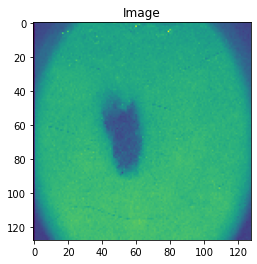

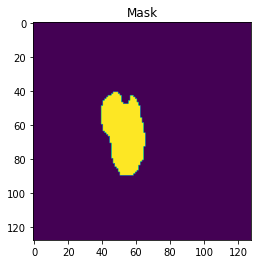

In [6]:
plt.imshow(images[0])
plt.title("Image")
plt.show()

plt.imshow(masks[0])  
plt.title("Mask")
plt.show()

In [7]:
num_imgs = len(images)
print(num_imgs)
num_masks = len(masks)
print(num_masks)
imgs = np.zeros((num_imgs, img_row, img_col))
masks_ = np.zeros_like(imgs)

for i in range(num_imgs):
    imgs[i] = images[i]
    
for i in range(num_imgs):
    masks_[i] = masks[i]
    


200
200


# Métricas de evaluación y entrenamiento (DICE)

In [8]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

## Representación de train y validación

In [9]:
def Representacion(history,epochnum, batchnum):
    print('Training time: %s' % (now() - t))

    #Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    
    plt.savefig('Graph_UNET.png')
    plt.show()

# U-NET

In [10]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [11]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [12]:
model = Network()
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_loss, metrics = [dsc])

In [13]:
color = 'ycbcr'
model_name = 'UNET'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [14]:
now = datetime.datetime.now
t = now()

for idx in range(4):
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    hist_df.to_csv(csv_path, index=False)


Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.6169 - dsc: 0.3846
Epoch 1: val_loss improved from inf to 0.58667, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 10s 774ms/step - loss: 0.6169 - dsc: 0.3846 - val_loss: 0.5867 - val_dsc: 0.4316 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.6150 - dsc: 0.3872
Epoch 2: val_loss improved from 0.58667 to 0.58473, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 743ms/step - loss: 0.6150 - dsc: 0.3872 - val_loss: 0.5847 - val_dsc: 0.4338 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.6134 - dsc: 0.3844
Epoch 3: val_loss improved from 0.58473 to 0.58184, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 8s 935ms/step - loss: 0.6134 - dsc: 0.3844 - val_loss: 0.5818 - val_dsc: 0.4369 - lr: 1.0000e-04
Epoch 4/100
9/9 [==

9/9 [==============================] - 7s 748ms/step - loss: 0.3240 - dsc: 0.6769 - val_loss: 0.3375 - val_dsc: 0.6581 - lr: 1.0000e-04
Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 0.3553 - dsc: 0.6478
Epoch 28: val_loss improved from 0.29313 to 0.29064, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 771ms/step - loss: 0.3553 - dsc: 0.6478 - val_loss: 0.2906 - val_dsc: 0.7328 - lr: 1.0000e-04
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.3304 - dsc: 0.6663
Epoch 29: val_loss did not improve from 0.29064
9/9 [==============================] - 7s 720ms/step - loss: 0.3304 - dsc: 0.6663 - val_loss: 0.3385 - val_dsc: 0.6565 - lr: 1.0000e-04
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.3315 - dsc: 0.6708
Epoch 30: val_loss improved from 0.29064 to 0.28358, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 782ms/step - loss: 0.3315

9/9 [==============================] - 7s 781ms/step - loss: 0.2371 - dsc: 0.7626 - val_loss: 0.2176 - val_dsc: 0.7870 - lr: 2.0000e-05
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.2375 - dsc: 0.7611
Epoch 55: val_loss improved from 0.21763 to 0.21405, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 746ms/step - loss: 0.2375 - dsc: 0.7611 - val_loss: 0.2141 - val_dsc: 0.7839 - lr: 2.0000e-05
Epoch 56/100
9/9 [==============================] - ETA: 0s - loss: 0.2461 - dsc: 0.7531
Epoch 56: val_loss did not improve from 0.21405
9/9 [==============================] - 7s 748ms/step - loss: 0.2461 - dsc: 0.7531 - val_loss: 0.2335 - val_dsc: 0.7609 - lr: 2.0000e-05
Epoch 57/100
9/9 [==============================] - ETA: 0s - loss: 0.2388 - dsc: 0.7672
Epoch 57: val_loss did not improve from 0.21405
9/9 [==============================] - 7s 733ms/step - loss: 0.2388 - dsc: 0.7672 - val_loss: 0.2187 - val_dsc: 0.7772 - lr:

Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.1614 - dsc: 0.8430
Epoch 81: val_loss improved from 0.12984 to 0.12972, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 772ms/step - loss: 0.1614 - dsc: 0.8430 - val_loss: 0.1297 - val_dsc: 0.8743 - lr: 2.0000e-05
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.1594 - dsc: 0.8366
Epoch 82: val_loss improved from 0.12972 to 0.12610, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 8s 918ms/step - loss: 0.1594 - dsc: 0.8366 - val_loss: 0.1261 - val_dsc: 0.8794 - lr: 2.0000e-05
Epoch 83/100
9/9 [==============================] - ETA: 0s - loss: 0.1578 - dsc: 0.8382
Epoch 83: val_loss improved from 0.12610 to 0.12594, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 748ms/step - loss: 0.1578 - dsc: 0.8382 - val_loss: 0.1259 - val_dsc: 0.8806 - lr: 2.0000e-05
Epoch 84/1

9/9 [==============================] - ETA: 0s - loss: 0.1403 - dsc: 0.8605
Epoch 7: val_loss did not improve from 0.14867
9/9 [==============================] - 7s 727ms/step - loss: 0.1403 - dsc: 0.8605 - val_loss: 0.1499 - val_dsc: 0.8586 - lr: 2.0000e-05
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.1353 - dsc: 0.8630
Epoch 8: val_loss improved from 0.14867 to 0.14844, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 788ms/step - loss: 0.1353 - dsc: 0.8630 - val_loss: 0.1484 - val_dsc: 0.8598 - lr: 2.0000e-05
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.1341 - dsc: 0.8676
Epoch 9: val_loss improved from 0.14844 to 0.14708, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 746ms/step - loss: 0.1341 - dsc: 0.8676 - val_loss: 0.1471 - val_dsc: 0.8607 - lr: 2.0000e-05
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.1336 - dsc: 0.8

9/9 [==============================] - ETA: 0s - loss: 0.1278 - dsc: 0.8745
Epoch 34: val_loss improved from 0.14067 to 0.14054, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 745ms/step - loss: 0.1278 - dsc: 0.8745 - val_loss: 0.1405 - val_dsc: 0.8676 - lr: 4.0000e-06
Epoch 35/100
9/9 [==============================] - ETA: 0s - loss: 0.1257 - dsc: 0.8743
Epoch 35: val_loss improved from 0.14054 to 0.14045, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 773ms/step - loss: 0.1257 - dsc: 0.8743 - val_loss: 0.1405 - val_dsc: 0.8674 - lr: 4.0000e-06
Epoch 36/100
9/9 [==============================] - ETA: 0s - loss: 0.1271 - dsc: 0.8743
Epoch 36: val_loss did not improve from 0.14045
9/9 [==============================] - 7s 719ms/step - loss: 0.1271 - dsc: 0.8743 - val_loss: 0.1408 - val_dsc: 0.8677 - lr: 4.0000e-06
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 0.1255 - dsc

Epoch 61/100
9/9 [==============================] - ETA: 0s - loss: 0.1247 - dsc: 0.8732
Epoch 61: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.

Epoch 61: val_loss did not improve from 0.13969
9/9 [==============================] - 7s 720ms/step - loss: 0.1247 - dsc: 0.8732 - val_loss: 0.1397 - val_dsc: 0.8685 - lr: 1.6000e-07
Epoch 62/100
9/9 [==============================] - ETA: 0s - loss: 0.1265 - dsc: 0.8744
Epoch 62: val_loss did not improve from 0.13969
9/9 [==============================] - 7s 754ms/step - loss: 0.1265 - dsc: 0.8744 - val_loss: 0.1397 - val_dsc: 0.8685 - lr: 3.2000e-08
Epoch 63/100
9/9 [==============================] - ETA: 0s - loss: 0.1233 - dsc: 0.8785
Epoch 63: val_loss did not improve from 0.13969
9/9 [==============================] - 6s 712ms/step - loss: 0.1233 - dsc: 0.8785 - val_loss: 0.1397 - val_dsc: 0.8685 - lr: 3.2000e-08
Epoch 64/100
9/9 [==============================] - ETA: 0s - loss: 0.1234 - dsc: 0.8745
Epoch 64: val_

Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1345 - dsc: 0.8674
Epoch 4: val_loss did not improve from 0.11349
9/9 [==============================] - 7s 771ms/step - loss: 0.1345 - dsc: 0.8674 - val_loss: 0.1135 - val_dsc: 0.8868 - lr: 5.1200e-11
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1373 - dsc: 0.8627
Epoch 5: val_loss did not improve from 0.11349
9/9 [==============================] - 7s 731ms/step - loss: 0.1373 - dsc: 0.8627 - val_loss: 0.1135 - val_dsc: 0.8868 - lr: 5.1200e-11
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1388 - dsc: 0.8551
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0239999126415712e-11.

Epoch 6: val_loss did not improve from 0.11349
9/9 [==============================] - 7s 741ms/step - loss: 0.1388 - dsc: 0.8551 - val_loss: 0.1135 - val_dsc: 0.8868 - lr: 5.1200e-11
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.1369 - dsc: 0.8654
Epoch 7: val_loss did

9/9 [==============================] - 6s 719ms/step - loss: 0.1197 - dsc: 0.8802 - val_loss: 0.1511 - val_dsc: 0.8530 - lr: 1.6384e-14
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1193 - dsc: 0.8836
Epoch 5: val_loss did not improve from 0.15106
9/9 [==============================] - 7s 733ms/step - loss: 0.1193 - dsc: 0.8836 - val_loss: 0.1511 - val_dsc: 0.8530 - lr: 1.6384e-14
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1192 - dsc: 0.8795
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.27679981130917e-15.

Epoch 6: val_loss did not improve from 0.15106
9/9 [==============================] - 7s 727ms/step - loss: 0.1192 - dsc: 0.8795 - val_loss: 0.1511 - val_dsc: 0.8530 - lr: 1.6384e-14
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.1217 - dsc: 0.8806
Epoch 7: val_loss did not improve from 0.15106
9/9 [==============================] - 8s 871ms/step - loss: 0.1217 - dsc: 0.8806 - val_loss: 0.1511 - val_dsc:

In [15]:
# Make predictions
t = now()
preds_UNET = model.predict(X_test)
print('Testing time: %s' % (now() - t))
print(len(X_train[112:140]))

2/2 [==============================] - 1s 77ms/step
Testing time: 0:00:00.595362
24


Training time: 0:00:00.598692


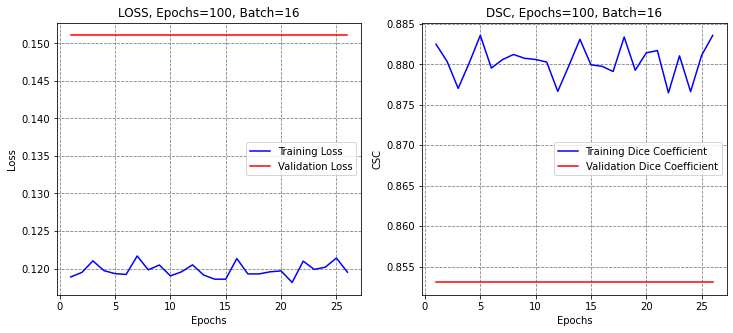

In [16]:
Representacion(history,epochnum, batchnum)

In [17]:
train_loss = history.history['loss']
epochsn = np.arange(1, len(train_loss)+1,1)
# Evaluate model
num_test = len(X_test)

# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_UNET.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.868 
 IOU 		0.775 
 Recall 	0.896 
 Precision	0.874
 Global Acc 	0.917
 AUC ROC 	0.912


************************************************************


In [18]:
preds_UNET_val = model.predict(X_val)
val_loss = history.history['val_loss']
epochsn = np.arange(1, len(val_loss)+1,1)
# Evaluate model
num_val = len(X_val)

# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_UNET_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


1/1 [==============================] - 0s 285ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.606 
 IOU 		0.452 
 Recall 	0.706 
 Precision	0.657
 Global Acc 	0.900
 AUC ROC 	0.900


************************************************************


# U-NET Dense

In [19]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [20]:
from keras.optimizers import *
from keras.models import *

def DenseUNet(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [21]:
color = 'ycbcr'
model_name = 'UNET_Dense'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [22]:
model = DenseUNet()
t = now()

for idx in range(4):
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    hist_df.to_csv(csv_path, index=False)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.5013 - dsc: 0.4982
Epoch 1: val_loss improved from inf to 0.58840, saving model to models/UNET_Dense-ycbcr-model-opt-0.keras
9/9 [==============================] - 28s 2s/step - loss: 0.5013 - dsc: 0.4982 - val_loss: 0.5884 - val_dsc: 0.4296 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.3824 - dsc: 0.6196
Epoch 2: val_loss did not improve from 0.58840
9/9 [==============================] - 14s 2s/step - loss: 0.3824 - dsc: 0.6196 - val_loss: 0.5954 - val_dsc: 0.4220 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2932 - dsc: 0.7090
Epoch 3: val_loss did not improve from 0.58840
9/9 [==============================] - 14s 2s/step - loss: 0.2932 - dsc: 0.7090 - val_loss: 0.6058 - val_dsc: 0.4106 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2659 - dsc: 0.7309
Epoch 4: val_loss did not improve from 0.58840
9/9 [======

9/9 [==============================] - ETA: 0s - loss: 0.1419 - dsc: 0.8529
Epoch 3: val_loss improved from 0.79845 to 0.77805, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 14s 2s/step - loss: 0.1419 - dsc: 0.8529 - val_loss: 0.7780 - val_dsc: 0.2060 - lr: 3.2000e-07
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1381 - dsc: 0.8599
Epoch 4: val_loss improved from 0.77805 to 0.74321, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 14s 2s/step - loss: 0.1381 - dsc: 0.8599 - val_loss: 0.7432 - val_dsc: 0.2397 - lr: 3.2000e-07
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1365 - dsc: 0.8659
Epoch 5: val_loss improved from 0.74321 to 0.70129, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 14s 2s/step - loss: 0.1365 - dsc: 0.8659 - val_loss: 0.7013 - val_dsc: 0.2808 - lr: 3.2000e-07
Epoch 6/100
9/9 

Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 0.1232 - dsc: 0.8758
Epoch 28: val_loss improved from 0.18021 to 0.17218, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 14s 2s/step - loss: 0.1232 - dsc: 0.8758 - val_loss: 0.1722 - val_dsc: 0.8163 - lr: 3.2000e-07
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.1395 - dsc: 0.8535
Epoch 29: val_loss improved from 0.17218 to 0.16506, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 14s 2s/step - loss: 0.1395 - dsc: 0.8535 - val_loss: 0.1651 - val_dsc: 0.8241 - lr: 3.2000e-07
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.1344 - dsc: 0.8663
Epoch 30: val_loss improved from 0.16506 to 0.15900, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1344 - dsc: 0.8663 - val_loss: 0.1590 - val_dsc: 0.8309 - lr: 3.2000e-0

9/9 [==============================] - 14s 2s/step - loss: 0.1324 - dsc: 0.8674 - val_loss: 0.1222 - val_dsc: 0.8753 - lr: 3.2000e-07
Epoch 53/100
9/9 [==============================] - ETA: 0s - loss: 0.1418 - dsc: 0.8594
Epoch 53: val_loss improved from 0.12218 to 0.12206, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1418 - dsc: 0.8594 - val_loss: 0.1221 - val_dsc: 0.8755 - lr: 3.2000e-07
Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 0.1441 - dsc: 0.8491
Epoch 54: val_loss improved from 0.12206 to 0.12187, saving model to models/UNET_Dense-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1441 - dsc: 0.8491 - val_loss: 0.1219 - val_dsc: 0.8757 - lr: 3.2000e-07
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.1353 - dsc: 0.8660
Epoch 55: val_loss improved from 0.12187 to 0.12175, saving model to models/UNET_Dense-ycbcr-model-opt-1.kera

Epoch 79/100
9/9 [==============================] - ETA: 0s - loss: 0.1319 - dsc: 0.8660
Epoch 79: val_loss did not improve from 0.12135
9/9 [==============================] - 14s 2s/step - loss: 0.1319 - dsc: 0.8660 - val_loss: 0.1217 - val_dsc: 0.8763 - lr: 2.5600e-09
Epoch 80/100
9/9 [==============================] - ETA: 0s - loss: 0.1449 - dsc: 0.8576
Epoch 80: val_loss did not improve from 0.12135
9/9 [==============================] - 14s 2s/step - loss: 0.1449 - dsc: 0.8576 - val_loss: 0.1217 - val_dsc: 0.8763 - lr: 2.5600e-09
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.1404 - dsc: 0.8614
Epoch 81: val_loss did not improve from 0.12135
9/9 [==============================] - 14s 1s/step - loss: 0.1404 - dsc: 0.8614 - val_loss: 0.1216 - val_dsc: 0.8764 - lr: 2.5600e-09
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.1463 - dsc: 0.8570
Epoch 82: val_loss did not improve from 0.12135
9/9 [==============================] - 14s 1s/step

9/9 [==============================] - 14s 1s/step - loss: 0.1442 - dsc: 0.8582 - val_loss: 0.1312 - val_dsc: 0.8755 - lr: 8.1920e-13
Epoch 15/100
9/9 [==============================] - ETA: 0s - loss: 0.1536 - dsc: 0.8454
Epoch 15: val_loss did not improve from 0.13028
9/9 [==============================] - 14s 2s/step - loss: 0.1536 - dsc: 0.8454 - val_loss: 0.1314 - val_dsc: 0.8754 - lr: 8.1920e-13
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 0.1424 - dsc: 0.8595
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.6384001360475466e-13.

Epoch 16: val_loss did not improve from 0.13028
9/9 [==============================] - 14s 2s/step - loss: 0.1424 - dsc: 0.8595 - val_loss: 0.1313 - val_dsc: 0.8754 - lr: 8.1920e-13
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 0.1416 - dsc: 0.8604
Epoch 17: val_loss did not improve from 0.13028
9/9 [==============================] - 14s 2s/step - loss: 0.1416 - dsc: 0.8604 - val_loss: 0.1311 - val_dsc

9/9 [==============================] - ETA: 0s - loss: 0.1471 - dsc: 0.8544
Epoch 16: val_loss did not improve from 0.12339
9/9 [==============================] - 14s 2s/step - loss: 0.1471 - dsc: 0.8544 - val_loss: 0.1240 - val_dsc: 0.8781 - lr: 1.0000e-15
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 0.1515 - dsc: 0.8513
Epoch 17: val_loss did not improve from 0.12339
9/9 [==============================] - 13s 1s/step - loss: 0.1515 - dsc: 0.8513 - val_loss: 0.1241 - val_dsc: 0.8781 - lr: 1.0000e-15
Epoch 18/100
9/9 [==============================] - ETA: 0s - loss: 0.1361 - dsc: 0.8611
Epoch 18: val_loss did not improve from 0.12339
9/9 [==============================] - 14s 1s/step - loss: 0.1361 - dsc: 0.8611 - val_loss: 0.1242 - val_dsc: 0.8780 - lr: 1.0000e-15
Epoch 19/100
9/9 [==============================] - ETA: 0s - loss: 0.1396 - dsc: 0.8568
Epoch 19: val_loss did not improve from 0.12339
9/9 [==============================] - 13s 1s/step - loss: 0.13

In [23]:
# Make predictions
t = now()
preds_Dense = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 1s 127ms/step
Testing time: 0:00:01.346897


Training time: 0:00:01.350121


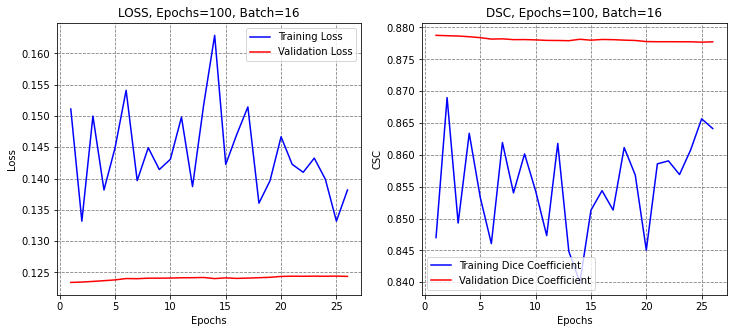

In [24]:
Representacion(history,epochnum,batchnum)

In [25]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Dense[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.435 
 IOU 		0.303 
 Recall 	0.445 
 Precision	0.430
 Global Acc 	0.959
 AUC ROC 	0.949


************************************************************


In [26]:
preds_Dense_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Dense_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Dense_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 0s 365ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.464 
 IOU 		0.332 
 Recall 	0.484 
 Precision	0.453
 Global Acc 	0.944
 AUC ROC 	0.935


************************************************************


# Attention U-NET

In [27]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [28]:
import keras_unet_collection
from keras_unet_collection._model_att_unet_2d import att_unet_2d

model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=1, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool='max', unpool=False,  
                           name='attunet')

In [29]:
color = 'ycbcr'
model_name = 'UNET_Att'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [30]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
import datetime
now = datetime.datetime.now
t = now()

for idx in range(4):
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)
    
    X_train = tf.convert_to_tensor(X_train)
    X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
    X_test = tf.convert_to_tensor(X_test)
    X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])
    Y_train = tf.convert_to_tensor(Y_train)
    Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])
    Y_test = tf.convert_to_tensor(Y_test)
    Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])
    X_val = tf.convert_to_tensor(X_val)
    X_val = tf.reshape(X_val, [X_val.shape[0],X_val.shape[1],X_val.shape[2],1])
    Y_val = tf.convert_to_tensor(Y_val)
    Y_val = tf.reshape(Y_val, [Y_val.shape[0],Y_val.shape[1],Y_val.shape[2],1])

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    hist_df.to_csv(csv_path, index=False)


Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4779 - dsc: 0.5204
Epoch 1: val_loss improved from inf to 0.58756, saving model to models/UNET_Att-ycbcr-model-opt-0.keras
9/9 [==============================] - 44s 5s/step - loss: 0.4779 - dsc: 0.5204 - val_loss: 0.5876 - val_dsc: 0.4306 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.3211 - dsc: 0.6832
Epoch 2: val_loss did not improve from 0.58756
9/9 [==============================] - 35s 4s/step - loss: 0.3211 - dsc: 0.6832 - val_loss: 0.5909 - val_dsc: 0.4269 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2753 - dsc: 0.7274
Epoch 3: val_loss did not improve from 0.58756
9/9 [==============================] - 36s 4s/step - loss: 0.2753 - dsc: 0.7274 - val_loss: 0.5986 - val_dsc: 0.4186 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2392 - dsc: 0.7587
Epoch 4: val_loss did not improve from 0.58756
9

9/9 [==============================] - 40s 5s/step - loss: 0.1760 - dsc: 0.8225 - val_loss: 0.7809 - val_dsc: 0.2138 - lr: 3.2000e-08
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1788 - dsc: 0.8161
Epoch 4: val_loss improved from 0.78090 to 0.77568, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 40s 5s/step - loss: 0.1788 - dsc: 0.8161 - val_loss: 0.7757 - val_dsc: 0.2192 - lr: 3.2000e-08
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1799 - dsc: 0.8139
Epoch 5: val_loss improved from 0.77568 to 0.76806, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 41s 5s/step - loss: 0.1799 - dsc: 0.8139 - val_loss: 0.7681 - val_dsc: 0.2269 - lr: 3.2000e-08
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1710 - dsc: 0.8306
Epoch 6: val_loss improved from 0.76806 to 0.75827, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [=====

9/9 [==============================] - 40s 4s/step - loss: 0.1843 - dsc: 0.8180 - val_loss: 0.2681 - val_dsc: 0.7350 - lr: 3.2000e-08
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.1708 - dsc: 0.8300
Epoch 29: val_loss improved from 0.26807 to 0.25422, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 40s 5s/step - loss: 0.1708 - dsc: 0.8300 - val_loss: 0.2542 - val_dsc: 0.7462 - lr: 3.2000e-08
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.1771 - dsc: 0.8138
Epoch 30: val_loss improved from 0.25422 to 0.24209, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 40s 5s/step - loss: 0.1771 - dsc: 0.8138 - val_loss: 0.2421 - val_dsc: 0.7561 - lr: 3.2000e-08
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.1830 - dsc: 0.8160
Epoch 31: val_loss improved from 0.24209 to 0.23175, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 

9/9 [==============================] - 40s 4s/step - loss: 0.1799 - dsc: 0.8222 - val_loss: 0.1531 - val_dsc: 0.8343 - lr: 3.2000e-08
Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 0.1798 - dsc: 0.8196
Epoch 54: val_loss improved from 0.15315 to 0.15293, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 41s 5s/step - loss: 0.1798 - dsc: 0.8196 - val_loss: 0.1529 - val_dsc: 0.8346 - lr: 3.2000e-08
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.1812 - dsc: 0.8137
Epoch 55: val_loss improved from 0.15293 to 0.15288, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 [==============================] - 40s 5s/step - loss: 0.1812 - dsc: 0.8137 - val_loss: 0.1529 - val_dsc: 0.8347 - lr: 3.2000e-08
Epoch 56/100
9/9 [==============================] - ETA: 0s - loss: 0.1782 - dsc: 0.8198
Epoch 56: val_loss improved from 0.15288 to 0.15278, saving model to models/UNET_Att-ycbcr-model-opt-1.keras
9/9 

9/9 [==============================] - ETA: 0s - loss: 0.1802 - dsc: 0.8110
Epoch 80: val_loss did not improve from 0.15158
9/9 [==============================] - 36s 4s/step - loss: 0.1802 - dsc: 0.8110 - val_loss: 0.1521 - val_dsc: 0.8365 - lr: 1.2800e-09
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.1687 - dsc: 0.8302
Epoch 81: val_loss did not improve from 0.15158
9/9 [==============================] - 36s 4s/step - loss: 0.1687 - dsc: 0.8302 - val_loss: 0.1521 - val_dsc: 0.8365 - lr: 1.2800e-09
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.1800 - dsc: 0.8163
Epoch 82: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.

Epoch 82: val_loss did not improve from 0.15158
9/9 [==============================] - 37s 4s/step - loss: 0.1800 - dsc: 0.8163 - val_loss: 0.1522 - val_dsc: 0.8363 - lr: 1.2800e-09
Epoch 83/100
9/9 [==============================] - ETA: 0s - loss: 0.1742 - dsc: 0.8282
Epoch 83: val_loss did not improve

9/9 [==============================] - 37s 4s/step - loss: 0.1957 - dsc: 0.8035 - val_loss: 0.1781 - val_dsc: 0.8319 - lr: 4.0960e-13
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.1804 - dsc: 0.8202
Epoch 12: val_loss did not improve from 0.17731
9/9 [==============================] - 36s 4s/step - loss: 0.1804 - dsc: 0.8202 - val_loss: 0.1781 - val_dsc: 0.8318 - lr: 8.1920e-14
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.1751 - dsc: 0.8267
Epoch 13: val_loss did not improve from 0.17731
9/9 [==============================] - 37s 4s/step - loss: 0.1751 - dsc: 0.8267 - val_loss: 0.1782 - val_dsc: 0.8318 - lr: 8.1920e-14
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 0.1764 - dsc: 0.8268
Epoch 14: val_loss did not improve from 0.17731
9/9 [==============================] - 37s 4s/step - loss: 0.1764 - dsc: 0.8268 - val_loss: 0.1781 - val_dsc: 0.8319 - lr: 8.1920e-14
Epoch 15/100
9/9 [==============================] - E

Epoch 15/100
9/9 [==============================] - ETA: 0s - loss: 0.1889 - dsc: 0.8118
Epoch 15: val_loss did not improve from 0.15334
9/9 [==============================] - 36s 4s/step - loss: 0.1889 - dsc: 0.8118 - val_loss: 0.1538 - val_dsc: 0.8410 - lr: 1.0000e-15
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 0.1768 - dsc: 0.8226
Epoch 16: val_loss did not improve from 0.15334
9/9 [==============================] - 37s 4s/step - loss: 0.1768 - dsc: 0.8226 - val_loss: 0.1538 - val_dsc: 0.8410 - lr: 1.0000e-15
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 0.1799 - dsc: 0.8161
Epoch 17: val_loss did not improve from 0.15334
9/9 [==============================] - 37s 4s/step - loss: 0.1799 - dsc: 0.8161 - val_loss: 0.1538 - val_dsc: 0.8409 - lr: 1.0000e-15
Epoch 18/100
9/9 [==============================] - ETA: 0s - loss: 0.1832 - dsc: 0.8149
Epoch 18: val_loss did not improve from 0.15334
9/9 [==============================] - 37s 4s/step

In [31]:
# Make predictions
t = now()
preds_Att = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 3s 469ms/step
Testing time: 0:00:02.561934


Training time: 0:00:02.565135


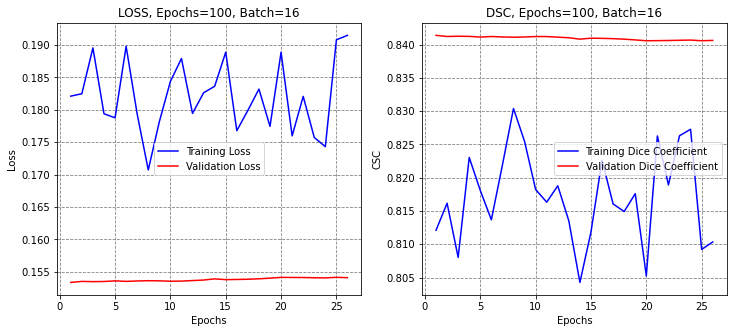

In [32]:
Representacion(history,epochnum,batchnum)

In [33]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Att[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Att.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.925 
 IOU 		0.864 
 Recall 	0.973 
 Precision	0.888
 Global Acc 	0.960
 AUC ROC 	0.947


************************************************************


In [34]:
preds_Att_val = model.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Att_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Att_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


1/1 [==============================] - 1s 1s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.922 
 IOU 		0.859 
 Recall 	0.977 
 Precision	0.880
 Global Acc 	0.953
 AUC ROC 	0.944


************************************************************


# U-NET Dense + Attended

In [35]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def Attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
    
    w = Add()([Wg,Ws])
 
    out = Activation("relu")(w)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    return Multiply()([out,s])

In [36]:
from keras.optimizers import *
from keras.models import *

def DenseUNet_AttGate(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    Att3 = Attention_gate(conv3,deconv3,start_neurons * 4)  
    uconv3 = concatenate([deconv3, Att3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    Att2 = Attention_gate(conv2,deconv2,start_neurons * 2)  
    uconv2 = concatenate([deconv2, Att2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    Att1 = Attention_gate(conv1,deconv1,start_neurons * 1)  
    uconv1 = concatenate([deconv1, Att1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [37]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
model2 = DenseUNet_AttGate()

In [38]:
color = 'ycbcr'
model_name = 'UNET_DenseAtt'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [39]:
now = datetime.datetime.now
t = now()

for idx in range(4):
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    hist_df.to_csv(csv_path, index=False)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4569 - dsc: 0.5560
Epoch 1: val_loss improved from inf to 0.59366, saving model to models/UNET_DenseAtt-ycbcr-model-opt-0.keras
9/9 [==============================] - 30s 2s/step - loss: 0.4569 - dsc: 0.5560 - val_loss: 0.5937 - val_dsc: 0.4240 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2687 - dsc: 0.7336
Epoch 2: val_loss did not improve from 0.59366
9/9 [==============================] - 15s 2s/step - loss: 0.2687 - dsc: 0.7336 - val_loss: 0.6152 - val_dsc: 0.4006 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2115 - dsc: 0.7840
Epoch 3: val_loss did not improve from 0.59366
9/9 [==============================] - 15s 2s/step - loss: 0.2115 - dsc: 0.7840 - val_loss: 0.6480 - val_dsc: 0.3652 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2160 - dsc: 0.7849
Epoch 4: val_loss did not improve from 0.59366
9/9 [===

9/9 [==============================] - 15s 2s/step - loss: 0.1261 - dsc: 0.8728 - val_loss: 0.9282 - val_dsc: 0.0709 - lr: 3.2000e-07
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1128 - dsc: 0.8884
Epoch 4: val_loss did not improve from 0.92582
9/9 [==============================] - 15s 2s/step - loss: 0.1128 - dsc: 0.8884 - val_loss: 0.9293 - val_dsc: 0.0698 - lr: 3.2000e-07
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1177 - dsc: 0.8838
Epoch 5: val_loss did not improve from 0.92582
9/9 [==============================] - 17s 2s/step - loss: 0.1177 - dsc: 0.8838 - val_loss: 0.9303 - val_dsc: 0.0689 - lr: 3.2000e-07
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1231 - dsc: 0.8733
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.

Epoch 6: val_loss did not improve from 0.92582
9/9 [==============================] - 17s 2s/step - loss: 0.1231 - dsc: 0.8733 - val_loss: 0.9277 - val_dsc: 0.0707

9/9 [==============================] - 15s 2s/step - loss: 0.1315 - dsc: 0.8706 - val_loss: 0.1863 - val_dsc: 0.8195 - lr: 6.4000e-08
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.1088 - dsc: 0.8902
Epoch 29: val_loss improved from 0.18634 to 0.17509, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1088 - dsc: 0.8902 - val_loss: 0.1751 - val_dsc: 0.8302 - lr: 6.4000e-08
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.1214 - dsc: 0.8785
Epoch 30: val_loss improved from 0.17509 to 0.16532, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1214 - dsc: 0.8785 - val_loss: 0.1653 - val_dsc: 0.8396 - lr: 6.4000e-08
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.1300 - dsc: 0.8695
Epoch 31: val_loss improved from 0.16532 to 0.15764, saving model to models/UNET_DenseAtt-ycbcr-model-o

Epoch 53/100
9/9 [==============================] - ETA: 0s - loss: 0.1125 - dsc: 0.8891
Epoch 53: val_loss improved from 0.10496 to 0.10470, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 16s 2s/step - loss: 0.1125 - dsc: 0.8891 - val_loss: 0.1047 - val_dsc: 0.8965 - lr: 6.4000e-08
Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 0.1125 - dsc: 0.8832
Epoch 54: val_loss improved from 0.10470 to 0.10448, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1125 - dsc: 0.8832 - val_loss: 0.1045 - val_dsc: 0.8967 - lr: 6.4000e-08
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.1145 - dsc: 0.8852
Epoch 55: val_loss improved from 0.10448 to 0.10430, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 15s 2s/step - loss: 0.1145 - dsc: 0.8852 - val_loss: 0.1043 - val_dsc: 0.8968 - lr: 

9/9 [==============================] - 15s 2s/step - loss: 0.1322 - dsc: 0.8660 - val_loss: 0.1039 - val_dsc: 0.8971 - lr: 2.5600e-09
Epoch 80/100
9/9 [==============================] - ETA: 0s - loss: 0.1182 - dsc: 0.8777
Epoch 80: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.

Epoch 80: val_loss did not improve from 0.10371
9/9 [==============================] - 15s 2s/step - loss: 0.1182 - dsc: 0.8777 - val_loss: 0.1039 - val_dsc: 0.8971 - lr: 2.5600e-09
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.1149 - dsc: 0.8823
Epoch 81: val_loss did not improve from 0.10371
9/9 [==============================] - 15s 2s/step - loss: 0.1149 - dsc: 0.8823 - val_loss: 0.1039 - val_dsc: 0.8970 - lr: 5.1200e-10
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.1192 - dsc: 0.8827
Epoch 82: val_loss did not improve from 0.10371
9/9 [==============================] - 15s 2s/step - loss: 0.1192 - dsc: 0.8827 - val_loss: 0.1039 - val_dsc: 0

Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.1382 - dsc: 0.8615
Epoch 10: val_loss did not improve from 0.11111
9/9 [==============================] - 15s 2s/step - loss: 0.1382 - dsc: 0.8615 - val_loss: 0.1111 - val_dsc: 0.8951 - lr: 4.0960e-12
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.1156 - dsc: 0.8853
Epoch 11: val_loss did not improve from 0.11111
9/9 [==============================] - 15s 2s/step - loss: 0.1156 - dsc: 0.8853 - val_loss: 0.1111 - val_dsc: 0.8951 - lr: 4.0960e-12
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.1270 - dsc: 0.8717
Epoch 12: val_loss did not improve from 0.11111
9/9 [==============================] - 15s 2s/step - loss: 0.1270 - dsc: 0.8717 - val_loss: 0.1112 - val_dsc: 0.8950 - lr: 4.0960e-12
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.1268 - dsc: 0.8743
Epoch 13: ReduceLROnPlateau reducing learning rate to 8.192000897078167e-13.

Epoch 13: val_loss d

Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1190 - dsc: 0.8794
Epoch 5: val_loss did not improve from 0.10605
9/9 [==============================] - 15s 2s/step - loss: 0.1190 - dsc: 0.8794 - val_loss: 0.1062 - val_dsc: 0.8962 - lr: 1.3107e-15
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1142 - dsc: 0.8855
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-15.

Epoch 6: val_loss did not improve from 0.10605
9/9 [==============================] - 14s 2s/step - loss: 0.1142 - dsc: 0.8855 - val_loss: 0.1063 - val_dsc: 0.8961 - lr: 1.3107e-15
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.1198 - dsc: 0.8807
Epoch 7: val_loss did not improve from 0.10605
9/9 [==============================] - 15s 2s/step - loss: 0.1198 - dsc: 0.8807 - val_loss: 0.1063 - val_dsc: 0.8961 - lr: 1.0000e-15
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.1168 - dsc: 0.8833
Epoch 8: val_loss did not improve from 0.106

In [40]:
# Make predictions
t = now()
preds_DA = model2.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 2s 150ms/step
Testing time: 0:00:01.560209


Training time: 0:00:01.563497


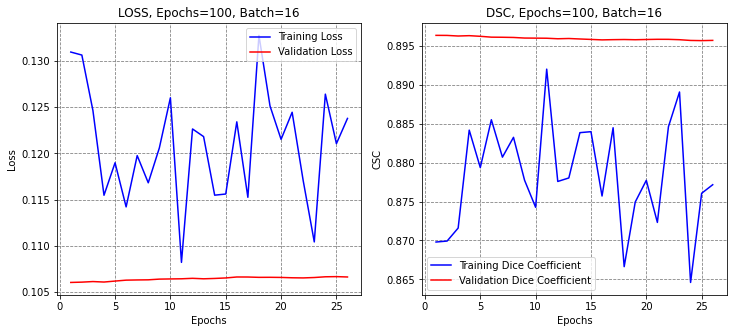

In [41]:
Representacion(history,epochnum,batchnum)

In [42]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_DA[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_DA.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.919 
 IOU 		0.853 
 Recall 	0.942 
 Precision	0.905
 Global Acc 	0.957
 AUC ROC 	0.949


************************************************************


In [43]:
preds_DA_val = model2.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_DA_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_DA_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 0s 385ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.917 
 IOU 		0.851 
 Recall 	0.957 
 Precision	0.891
 Global Acc 	0.945
 AUC ROC 	0.937


************************************************************


# U-NET 3+

In [44]:
from keras_unet_collection import models, base, utils
model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256


In [45]:
color = 'ycbcr'
model_name = 'UNET_3+'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [46]:
now = datetime.datetime.now
t = now()
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[dsc]) # lr adaptativo

for idx in range(4):
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    hist_df.to_csv(csv_path, index=False)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4552 - dsc: 0.5562
Epoch 1: val_loss improved from inf to 0.59064, saving model to models/UNET_3+-ycbcr-model-opt-0.keras
9/9 [==============================] - 61s 6s/step - loss: 0.4552 - dsc: 0.5562 - val_loss: 0.5906 - val_dsc: 0.4273 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2103 - dsc: 0.7863
Epoch 2: val_loss did not improve from 0.59064
9/9 [==============================] - 56s 6s/step - loss: 0.2103 - dsc: 0.7863 - val_loss: 0.6138 - val_dsc: 0.4021 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.1622 - dsc: 0.8382
Epoch 3: val_loss did not improve from 0.59064
9/9 [==============================] - 56s 6s/step - loss: 0.1622 - dsc: 0.8382 - val_loss: 0.6619 - val_dsc: 0.3503 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1579 - dsc: 0.8363
Epoch 4: val_loss did not improve from 0.59064
9/

9/9 [==============================] - 56s 6s/step - loss: 0.0943 - dsc: 0.9067 - val_loss: 0.9951 - val_dsc: 0.0049 - lr: 3.2000e-08
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.0958 - dsc: 0.9040
Epoch 4: val_loss did not improve from 0.99474
9/9 [==============================] - 57s 6s/step - loss: 0.0958 - dsc: 0.9040 - val_loss: 0.9952 - val_dsc: 0.0047 - lr: 3.2000e-08
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.0914 - dsc: 0.9062
Epoch 5: val_loss did not improve from 0.99474
9/9 [==============================] - 56s 6s/step - loss: 0.0914 - dsc: 0.9062 - val_loss: 0.9952 - val_dsc: 0.0048 - lr: 3.2000e-08
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.0929 - dsc: 0.9084
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.

Epoch 6: val_loss did not improve from 0.99474
9/9 [==============================] - 56s 6s/step - loss: 0.0929 - dsc: 0.9084 - val_loss: 0.9948 - val_dsc: 0.0051

Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.0917 - dsc: 0.9087
Epoch 29: val_loss improved from 0.39780 to 0.36839, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 61s 7s/step - loss: 0.0917 - dsc: 0.9087 - val_loss: 0.3684 - val_dsc: 0.6708 - lr: 6.4000e-09
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.0889 - dsc: 0.9082
Epoch 30: val_loss improved from 0.36839 to 0.34133, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0889 - dsc: 0.9082 - val_loss: 0.3413 - val_dsc: 0.6981 - lr: 6.4000e-09
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.0919 - dsc: 0.9071
Epoch 31: val_loss improved from 0.34133 to 0.31255, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0919 - dsc: 0.9071 - val_loss: 0.3126 - val_dsc: 0.7257 - lr: 6.4000e-09
Epoch 3

Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 0.0866 - dsc: 0.9138
Epoch 54: val_loss improved from 0.10618 to 0.10497, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 64s 7s/step - loss: 0.0866 - dsc: 0.9138 - val_loss: 0.1050 - val_dsc: 0.9077 - lr: 6.4000e-09
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.0936 - dsc: 0.9038
Epoch 55: val_loss improved from 0.10497 to 0.10391, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 59s 6s/step - loss: 0.0936 - dsc: 0.9038 - val_loss: 0.1039 - val_dsc: 0.9086 - lr: 6.4000e-09
Epoch 56/100
9/9 [==============================] - ETA: 0s - loss: 0.0886 - dsc: 0.9133
Epoch 56: val_loss improved from 0.10391 to 0.10320, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0886 - dsc: 0.9133 - val_loss: 0.1032 - val_dsc: 0.9093 - lr: 6.4000e-09
Epoch 5


Epoch 79: val_loss did not improve from 0.09911
9/9 [==============================] - 56s 6s/step - loss: 0.0977 - dsc: 0.9045 - val_loss: 0.0991 - val_dsc: 0.9127 - lr: 6.4000e-09
Epoch 80/100
9/9 [==============================] - ETA: 0s - loss: 0.0885 - dsc: 0.9103
Epoch 80: val_loss did not improve from 0.09911
9/9 [==============================] - 56s 6s/step - loss: 0.0885 - dsc: 0.9103 - val_loss: 0.0991 - val_dsc: 0.9127 - lr: 1.2800e-09
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.0943 - dsc: 0.9073
Epoch 81: val_loss did not improve from 0.09911
9/9 [==============================] - 56s 6s/step - loss: 0.0943 - dsc: 0.9073 - val_loss: 0.0992 - val_dsc: 0.9127 - lr: 1.2800e-09
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.0907 - dsc: 0.9102
Epoch 82: val_loss improved from 0.09911 to 0.09910, saving model to models/UNET_3+-ycbcr-model-opt-1.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0907 - dsc: 0.910

Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.0991 - dsc: 0.8986
Epoch 7: val_loss improved from 0.07933 to 0.07927, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0991 - dsc: 0.8986 - val_loss: 0.0793 - val_dsc: 0.9228 - lr: 2.0480e-12
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.1065 - dsc: 0.8961
Epoch 8: val_loss did not improve from 0.07927
9/9 [==============================] - 56s 6s/step - loss: 0.1065 - dsc: 0.8961 - val_loss: 0.0793 - val_dsc: 0.9228 - lr: 2.0480e-12
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.1122 - dsc: 0.8894
Epoch 9: val_loss improved from 0.07927 to 0.07926, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 57s 6s/step - loss: 0.1122 - dsc: 0.8894 - val_loss: 0.0793 - val_dsc: 0.9228 - lr: 2.0480e-12
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.103

9/9 [==============================] - ETA: 0s - loss: 0.1048 - dsc: 0.8952
Epoch 34: val_loss did not improve from 0.07882
9/9 [==============================] - 57s 6s/step - loss: 0.1048 - dsc: 0.8952 - val_loss: 0.0789 - val_dsc: 0.9233 - lr: 8.1920e-14
Epoch 35/100
9/9 [==============================] - ETA: 0s - loss: 0.1086 - dsc: 0.8851
Epoch 35: val_loss improved from 0.07882 to 0.07882, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 57s 6s/step - loss: 0.1086 - dsc: 0.8851 - val_loss: 0.0788 - val_dsc: 0.9233 - lr: 8.1920e-14
Epoch 36/100
9/9 [==============================] - ETA: 0s - loss: 0.1075 - dsc: 0.8949
Epoch 36: val_loss improved from 0.07882 to 0.07881, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 58s 6s/step - loss: 0.1075 - dsc: 0.8949 - val_loss: 0.0788 - val_dsc: 0.9233 - lr: 8.1920e-14
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 0.1050 - dsc

Epoch 62/100
9/9 [==============================] - ETA: 0s - loss: 0.1045 - dsc: 0.8926
Epoch 62: val_loss did not improve from 0.07873
9/9 [==============================] - 56s 6s/step - loss: 0.1045 - dsc: 0.8926 - val_loss: 0.0789 - val_dsc: 0.9232 - lr: 1.0000e-15
Epoch 63/100
9/9 [==============================] - ETA: 0s - loss: 0.1076 - dsc: 0.8938
Epoch 63: val_loss did not improve from 0.07873
9/9 [==============================] - 60s 7s/step - loss: 0.1076 - dsc: 0.8938 - val_loss: 0.0789 - val_dsc: 0.9232 - lr: 1.0000e-15
Epoch 64/100
9/9 [==============================] - ETA: 0s - loss: 0.0960 - dsc: 0.9030
Epoch 64: val_loss did not improve from 0.07873
9/9 [==============================] - 60s 7s/step - loss: 0.0960 - dsc: 0.9030 - val_loss: 0.0789 - val_dsc: 0.9232 - lr: 1.0000e-15
Epoch 65/100
9/9 [==============================] - ETA: 0s - loss: 0.0925 - dsc: 0.9065
Epoch 65: val_loss did not improve from 0.07873
9/9 [==============================] - 57s 6s/step

9/9 [==============================] - ETA: 0s - loss: 0.1011 - dsc: 0.8939
Epoch 10: val_loss did not improve from 0.08753
9/9 [==============================] - 56s 6s/step - loss: 0.1011 - dsc: 0.8939 - val_loss: 0.0876 - val_dsc: 0.9190 - lr: 1.0000e-15
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.0926 - dsc: 0.9094
Epoch 11: val_loss did not improve from 0.08753
9/9 [==============================] - 56s 6s/step - loss: 0.0926 - dsc: 0.9094 - val_loss: 0.0878 - val_dsc: 0.9189 - lr: 1.0000e-15
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.0962 - dsc: 0.9064
Epoch 12: val_loss did not improve from 0.08753
9/9 [==============================] - 56s 6s/step - loss: 0.0962 - dsc: 0.9064 - val_loss: 0.0879 - val_dsc: 0.9187 - lr: 1.0000e-15
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.0919 - dsc: 0.9094
Epoch 13: val_loss did not improve from 0.08753
9/9 [==============================] - 56s 6s/step - loss: 0.09

In [47]:
# Make predictions
t = now()
preds_3p = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 4s 684ms/step
Testing time: 0:00:08.852027


Training time: 0:00:08.855052


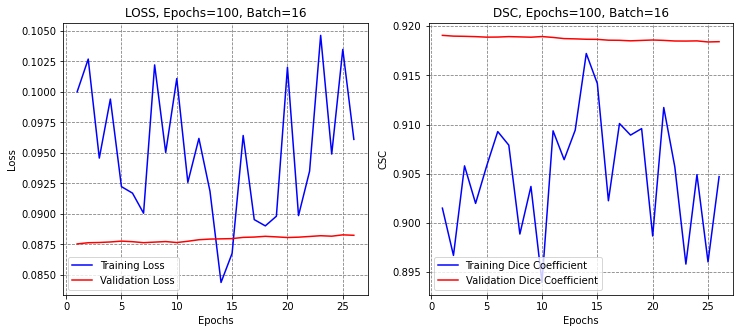

In [48]:
Representacion(history,epochnum,batchnum)

In [49]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_3p[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_3p.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.425 
 IOU 		0.291 
 Recall 	0.421 
 Precision	0.433
 Global Acc 	0.953
 AUC ROC 	0.950


************************************************************


In [50]:
preds_3p_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_3p_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_3p_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 2s 2s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.449 
 IOU 		0.316 
 Recall 	0.450 
 Precision	0.456
 Global Acc 	0.942
 AUC ROC 	0.939


************************************************************


# Representación de las mascaras 

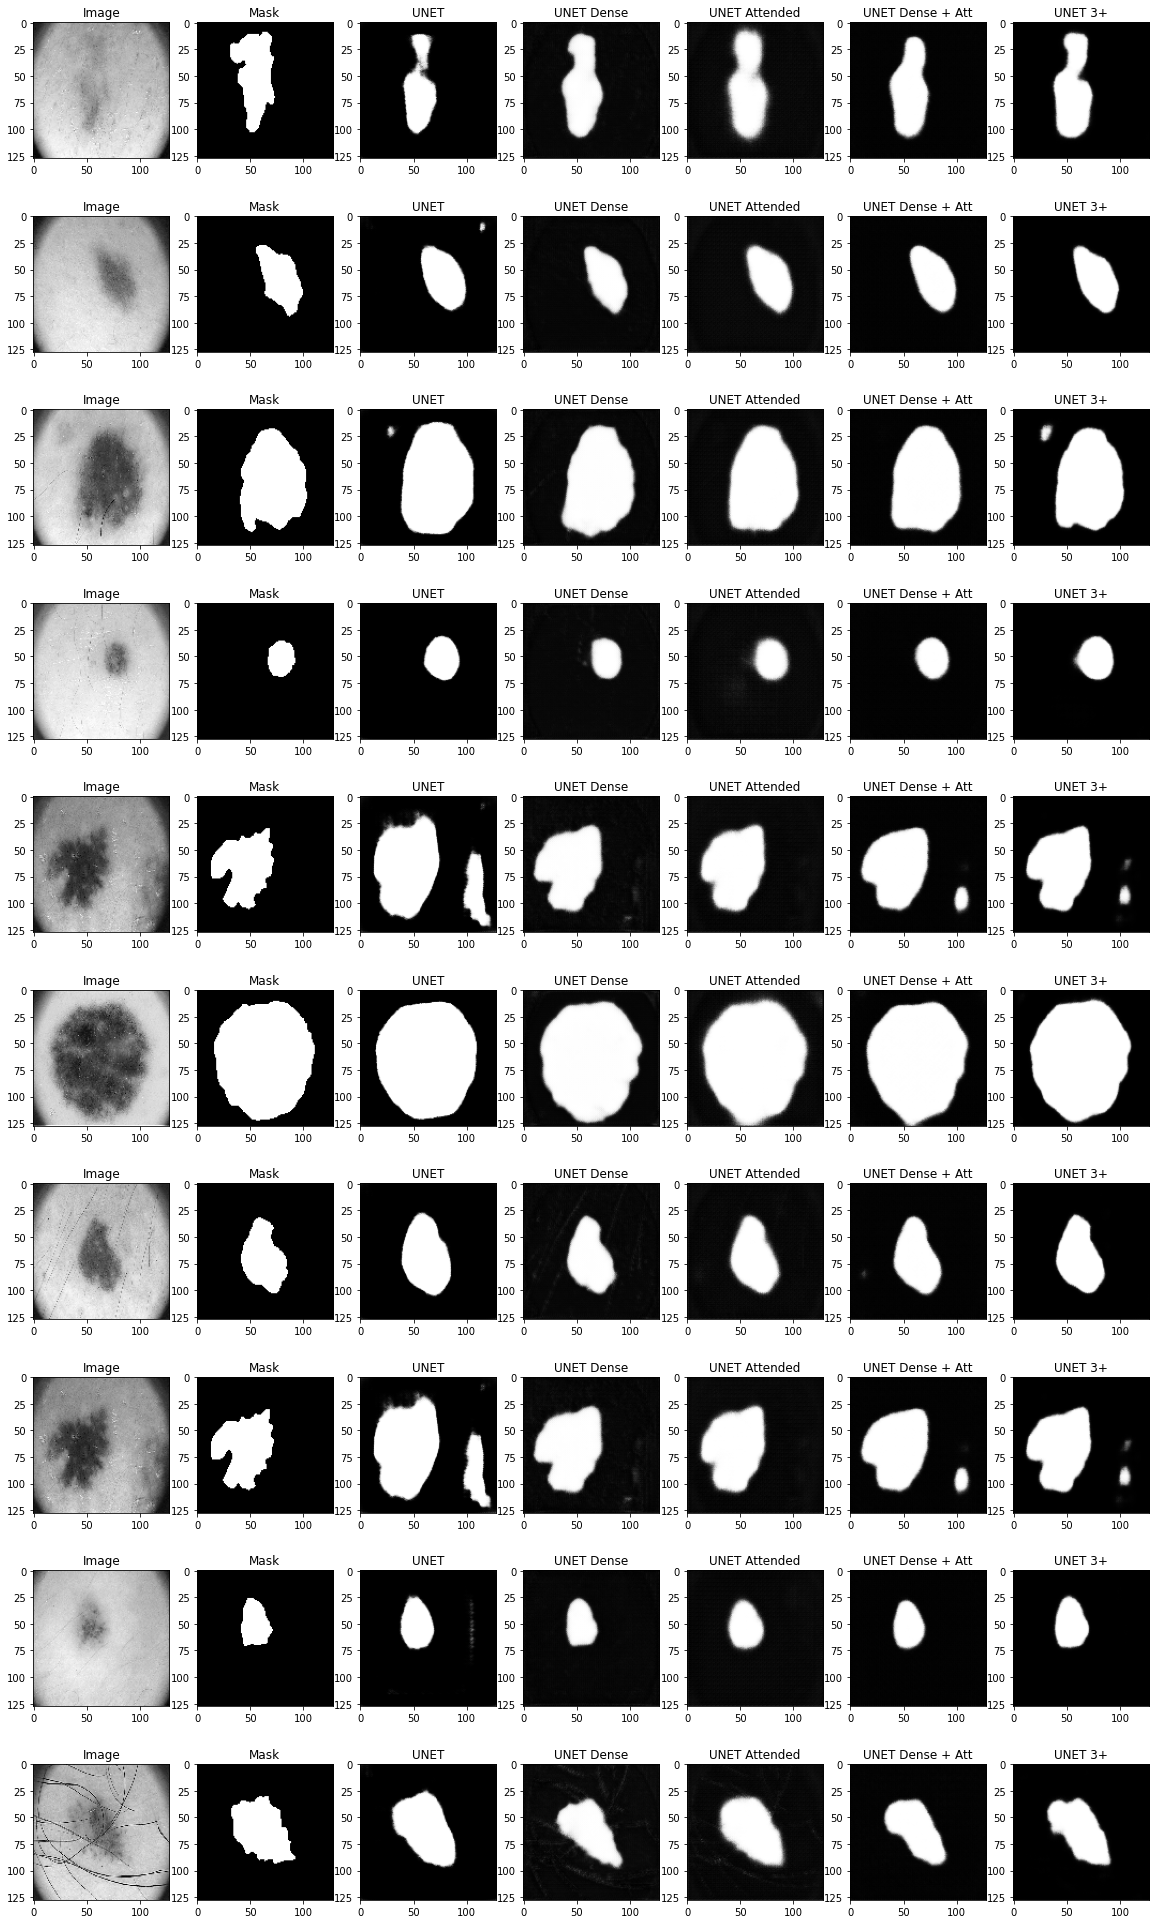

In [51]:
# To plot a set of images with predicted masks uncomment these lines
j = 0
import random
n1 = random.randint(0,len(X_test)-1)
n2 = random.randint(0,len(X_test)-1)
n3 = random.randint(0,len(X_test)-1)
n4 = random.randint(0,len(X_test)-1)
n5 = random.randint(0,len(X_test)-1)
n6 = random.randint(0,len(X_test)-1)
n7 = random.randint(0,len(X_test)-1)
n8 = random.randint(0,len(X_test)-1)
n9 = random.randint(0,len(X_test)-1)
n10 = random.randint(0,len(X_test)-1)

num_disp = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10]
j=1
plt.figure(figsize = (20,35))
for i in num_disp:
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(Y_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_UNET[i]),cmap='gray')
    plt.title('UNET')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Dense[i]),cmap='gray')
    plt.title('UNET Dense')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Att[i]),cmap='gray')
    plt.title('UNET Attended')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_DA[i]),cmap='gray')
    plt.title('UNET Dense + Att')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_3p[i]),cmap='gray')
    plt.title('UNET 3+')
    j +=1
    

plt.savefig('Masks.png')
plt.show()